In [1]:
# Add module to path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# Imports
from aoc23.utils import read_input
import matplotlib.pyplot as plt

In [3]:
input_16 = read_input(16)

## Part 1

For part 1 of the [day 16 puzzle](https://adventofcode.com/2023/day/16), we are given an array containing 5 different types of characters, each representing something different at each tile inside a box of mirrors and beam splitters:

- `/` = a double-sided mirror lying at 45° in the NE-SW orientation. Light beams are reflected by 90° in the obvious directions
- `\` = a double-sided mirror lying at 45° in the NW-SE orientation. Light beams are reflected by 90° in the obvious directions
- `|` = a beam splitter, lying in the N-S orientation. When a beam of light hits the splitter from the east or west, the beam is split in two and reflected both north and south. If hit from the north or south, the beam moves through without interference
- `-` = a beam splitter, lying in the E-W orientation. When a beam of light hits the splitter from the north or south, the beam is split in two and reflected both east and west. If hit from the east or west, the beam moves through without interference
- `.` = an empty tile.

A beam of light is shone into the box from the NW tile (i.e. at index $(0, 0)$), in an eastern direction; we are asked to find the path of travel of the beam, as well as the total number of tiles which are illuminated.

The first job is to codify the effects that the different tile types have on approaching beams of light. The dictionary `light_direction` will provide the outgoing direction (or directions, for splitters), when provided with a tile type and an incoming beam direction:

In [4]:
light_direction = {}

# .
light_direction[('.', 'n')] = 'n'
light_direction[('.', 'e')] = 'e'
light_direction[('.', 's')] = 's'
light_direction[('.', 'w')] = 'w'

# /
light_direction[('/', 'n')] = 'e'
light_direction[('/', 'e')] = 'n'
light_direction[('/', 's')] = 'w'
light_direction[('/', 'w')] = 's'

# \
light_direction[('\\', 'n')] = 'w'
light_direction[('\\', 'e')] = 's'
light_direction[('\\', 's')] = 'e'
light_direction[('\\', 'w')] = 'n'

# |
light_direction[('|', 'n')] = 'n'
light_direction[('|', 's')] = 'w'

# F
light_direction[('F', 'n')] = 'e'
light_direction[('F', 'w')] = 's'

# 7
light_direction[('7', 'n')] = 'w'
light_direction[('7', 'e')] = 's'

# |
light_direction[('|', 'n')] = 'n'
light_direction[('|', 's')] = 's'
light_direction[('|', 'e')] = 'ns'
light_direction[('|', 'w')] = 'ns'

# -
light_direction[('-', 'n')] = 'we'
light_direction[('-', 's')] = 'we'
light_direction[('-', 'e')] = 'e'
light_direction[('-', 'w')] = 'w'

The following function is borrowed from a previous puzzle ([day 10](../aoc23-day10)), and converts an array index and direction into a new array index, by taking a step in the provided direction:

In [5]:
def new_index(row: int, col: int, direction: str):
    match direction:
        case 'n':
            return (row-1, col)
        case 'e':
            return (row, col+1)
        case 's':
            return (row+1, col)
        case 'w':
            return (row, col-1)
        case '_':
            raise ValueError(f'direction {direction} not recognised!')

The best data structure to use for this problem is a stack, and we can proceed to work our way through the grid using a depth-first search (DFS) approach. This is needed, as we will need to keep track of each 'child' beam created by the splitters, until the each beam hits the edge of the array, or ends up in an infinite loop. The stack is initialised with a single 'state' (a state consists of a tile along with an incoming direction), that being the initial tile and the incoming direction of the light beam. At each iteration:

1. The top element of the stack is taken
2. The new direction(s) are calculated, given the tile type, and a step is taken in that direction if possible
3. The new state(s) are added to the top of the stack, if they haven't been visited before.

This implementation takes advantage of a native Python `list` to implement the stack, and keeps track of all the states visited so far to avoid getting stuck in infinite loops:

In [6]:
def find_charged_tiles(grid: list[str], 
                       start_tile: tuple[int] = None, 
                       start_direction: str = 'e') -> set[tuple[int]]:
    n_rows = len(grid)
    n_cols = len(grid[0])
    start_tile = start_tile or (0, 0)
    
    # Keep track of charged tiles in a set
    # Use stack to keep track of visited tiles with direction
    charged_tiles = set()
    stack = [(start_tile, start_direction)]

    # Continue while there still exist visited tiles on stack
    while len(stack) > 0:
        
        # Take next visited tile from stack
        (row, col), direction = stack.pop()
        charged_tiles.add(((row, col), direction))
        tile_type = grid[row][col]
        direction = light_direction[(tile_type, direction)]
        
        # May have multiple directions from splitter
        for char in direction:
            # Check if going off edge of grid
            row, col = new_index(row, col, char)
            valid_index = (0 <= row < n_rows) and (0 <= col < n_cols)
            
            # Check if we have already seen this (tile, direction) pair
            # Without this check, we can go round in circles forever
            seen_state = ((row, col), direction) in charged_tiles
            
            if valid_index and not seen_state:
                stack.append(((row, col), char))
    
    # Drop directions, just return tiles
    return set([tile[0] for tile in charged_tiles])

The following function is a useful way of visualising the resulting path that the beam takes through the grid - the path is given by the yellow tiles, and the starting point by the green tile.

In [7]:
def visualise_charged_tiles(grid: list[str], 
                            charged_tiles: set(tuple[int]), 
                            start_tile: tuple[int], 
                            plot_factor: float = None):
    n_rows = len(grid)
    n_cols = len(grid[0])
    plot_factor = plot_factor or 15/n_cols
    
    # Construct binary matrix, with 1s along the beam path
    mat = []
    for i in range(n_rows):
        line = []
        for j in range(n_cols):
            if (i, j) in charged_tiles:
                line.append(1)
            else:
                line.append(0)
        mat.append(line)
        
    # Indicate the starting tile
    mat[start_tile[0]][start_tile[1]] = 0.75
    
    # Plot path, along with tile types
    fig, ax = plt.subplots(figsize=(plot_factor*n_cols, plot_factor*n_rows))
    ax.matshow(mat)
    for i in range(n_rows):
        for j in range(n_cols):
            text = ax.text(j, i, grid[i][j].replace('-', '--'),
                           ha="center", va="center", color="b")

Let's test these functions of the test grid, provided by the puzzle:

In [8]:
# Load test grid from local file
with open(f"../data/day16_test.txt", 'r') as f:
    filestring = f.read()

test_grid = filestring.split('\n')

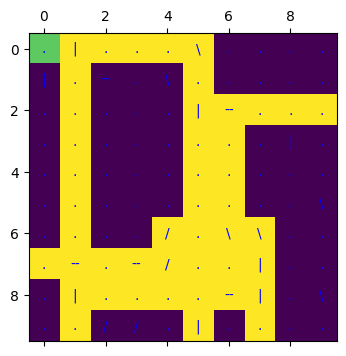

In [9]:
# Compute path + visualise
test_charged_tiles = find_charged_tiles(test_grid)

visualise_charged_tiles(test_grid, 
                        test_charged_tiles, 
                        start_tile=(0, 0), 
                        plot_factor=0.4)

Following the beam of light from the starting tile, this looks like it is working as intended; check also that the total number of illuminated tiles matches the expected number:

In [10]:
assert len(test_charged_tiles) == 46
print('Success!')

Success!


Moving on to the full input array:

In [11]:
charged_tiles = find_charged_tiles(input_16)

In [12]:
len(charged_tiles)

6605

And so the answer to part 1 is: __6605__. Here is a visualisation of the full path taken by the light beam (the starting square is just visible in the top left):

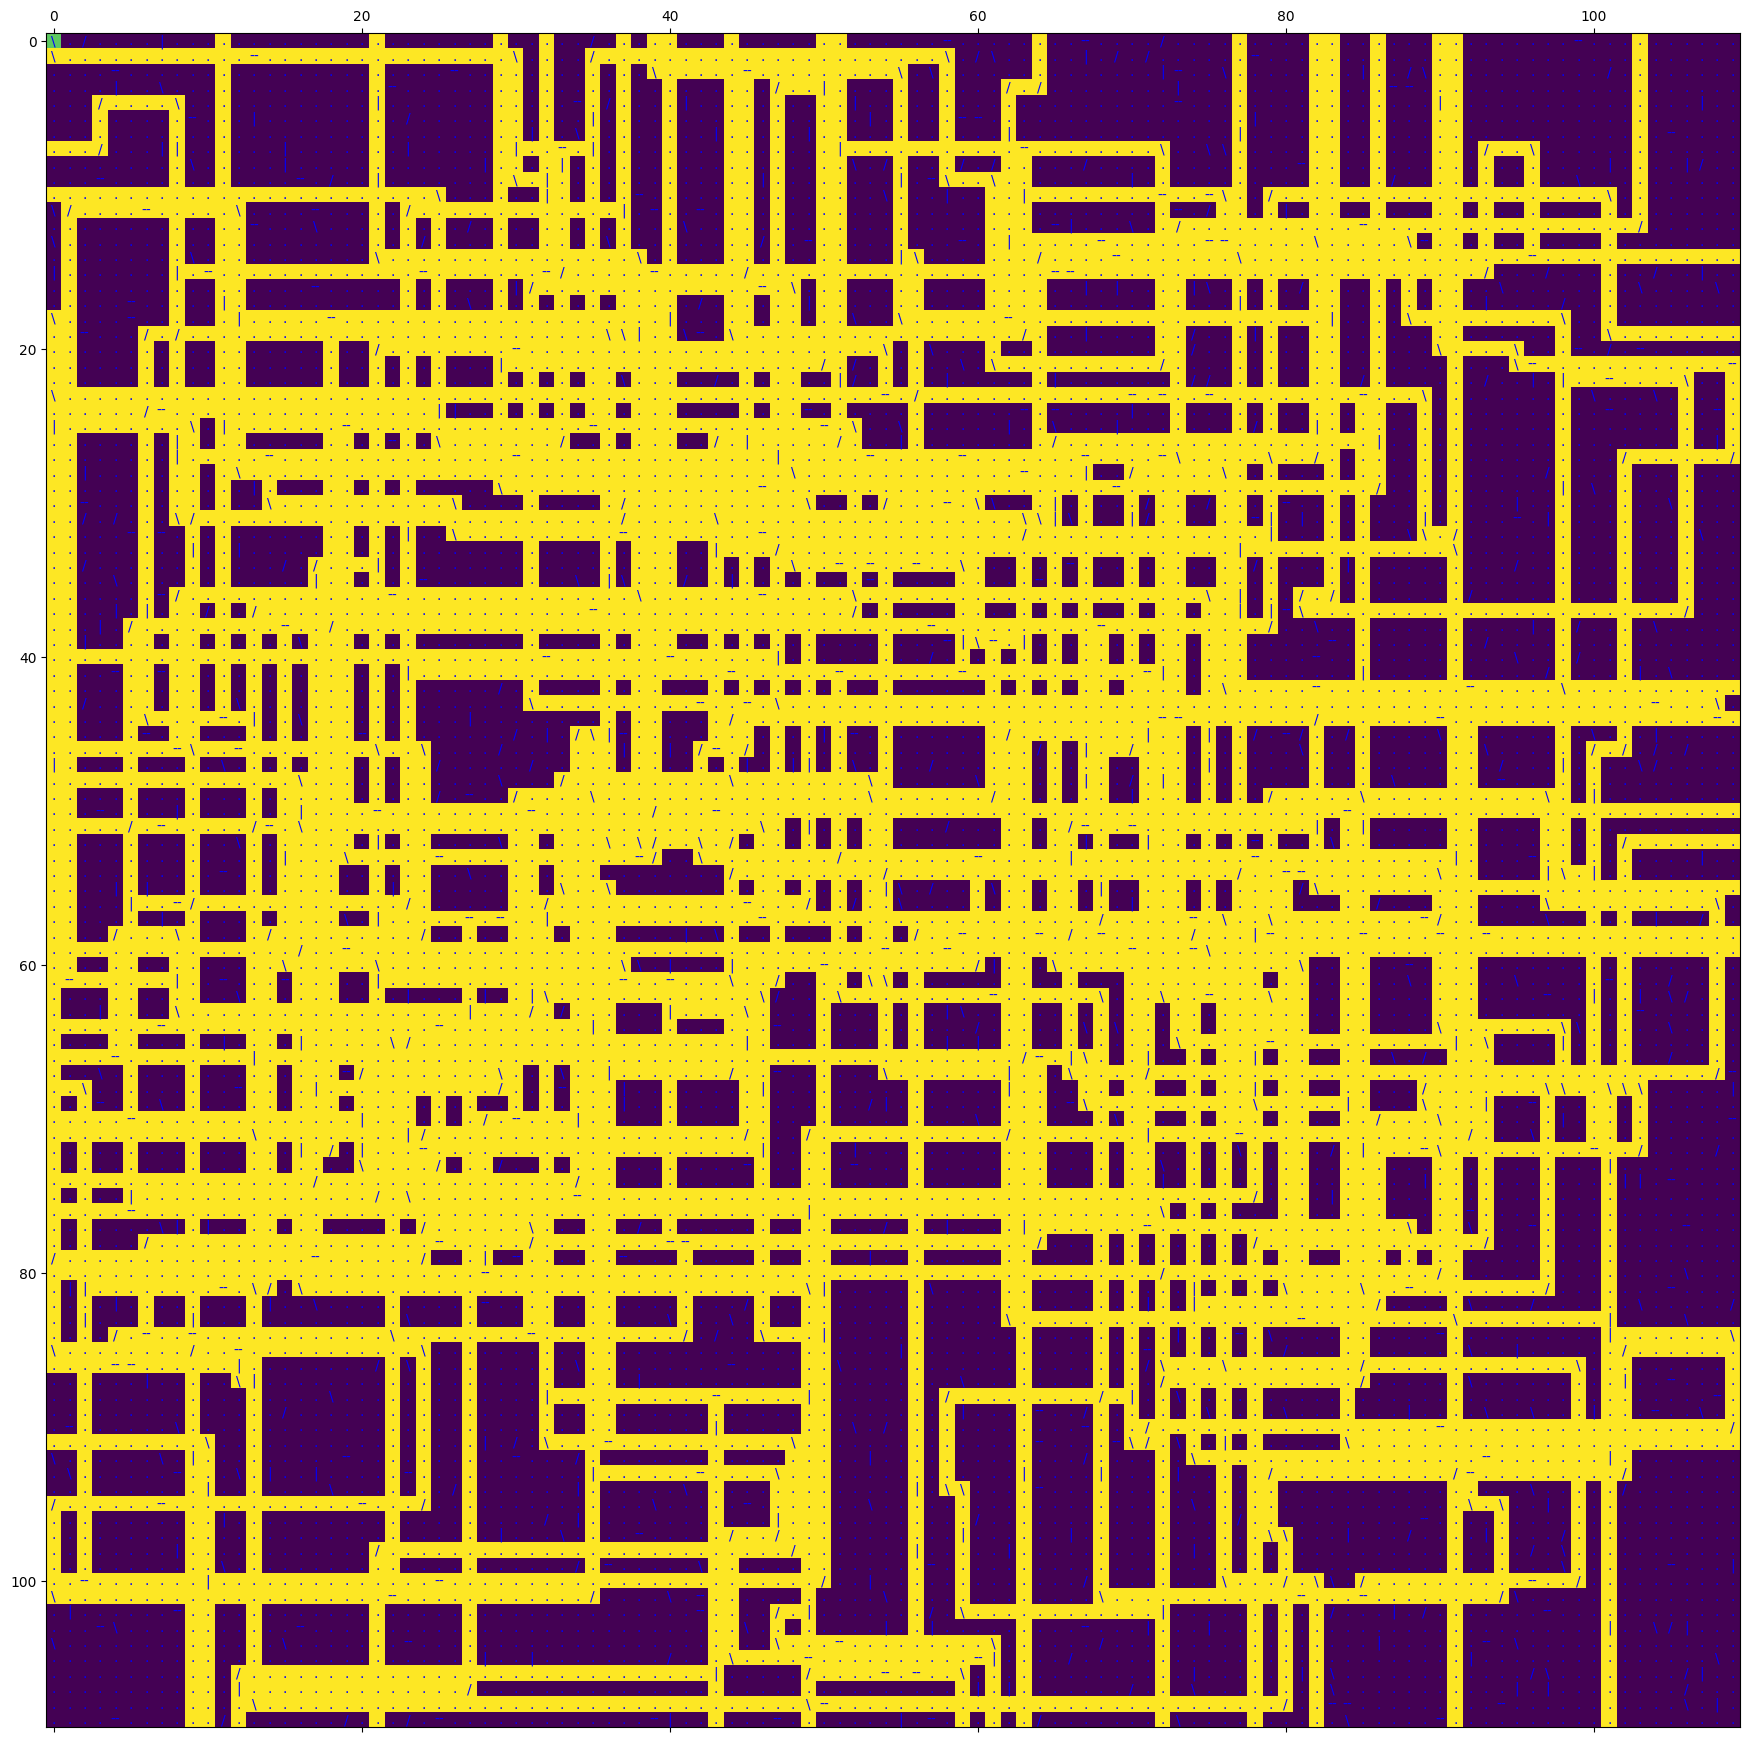

In [13]:
visualise_charged_tiles(input_16, 
                        charged_tiles, 
                        start_tile=(0, 0), 
                        plot_factor=0.2)

## Part 2

The second part of this puzzle asks us to find the starting tile and initial direction which result in the maximum number of illuminated tiles. The earlier implementation is efficient enough that this is simply possible by iterating over all the different possible configurations:

In [14]:
def maximise_charged_tiles(grid: list[str]) -> tuple[tuple[int], str, int]:
    n_rows = len(grid)
    n_cols = len(grid[0])
    
    # Keep track of maximums
    max_charge = 0
    max_start_tile = None
    max_direction = None
    
    # Top edge
    for j in range(n_cols):
        n = len(find_charged_tiles(grid, start_tile=(0, j), start_direction='s'))
        if n > max_charge:
            max_charge = n
            max_start_tile = (0, j)
            max_direction = 's'
    
    # Left edge
    for i in range(n_rows):
        n = len(find_charged_tiles(grid, start_tile=(i, 0), start_direction='e'))
        if n > max_charge:
            max_charge = n
            max_start_tile = (i, 0)
            max_direction = 'e'
    
    # Bottom edge
    for j in range(n_cols):
        n = len(find_charged_tiles(grid, start_tile=(n_rows-1, j), start_direction='n'))
        if n > max_charge:
            max_charge = n
            max_start_tile = (n_rows-1, j)
            max_direction = 'n'
    
    # Right edge
    for i in range(n_rows):
        n = len(find_charged_tiles(grid, start_tile=(i, n_cols-1), start_direction='w'))
        if n > max_charge:
            max_charge = n
            max_start_tile = (i, n_cols-1)
            max_direction = 'w'
    
    return max_start_tile, max_direction, max_charge

Let's test this out on the smaller test grid:

In [15]:
max_test_start_tile, max_test_direction, max_test_charge = maximise_charged_tiles(test_grid)
print(f'Maximum of {max_test_charge} reached by heading {max_test_direction.upper()} from tile {max_test_start_tile}')

Maximum of 51 reached by heading S from tile (0, 3)


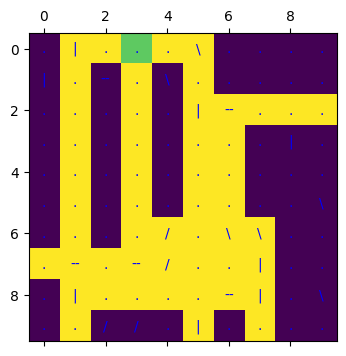

In [16]:
max_test_charged_tiles = find_charged_tiles(test_grid, 
                                            start_tile=max_test_start_tile, 
                                            start_direction=max_test_direction)

visualise_charged_tiles(test_grid, 
                        max_test_charged_tiles, 
                        max_test_start_tile, 
                        plot_factor=0.4)

As expected, there a larger number of illuminated tiles starting with this configuration (51 instead of 46).

Now, applying this to the full input array:

In [17]:
max_start_tile, max_direction, max_charge = maximise_charged_tiles(input_16)
print(f'Maximum of {max_charge} reached by heading {max_direction.upper()} from tile {max_start_tile}')

Maximum of 6766 reached by heading N from tile (109, 19)


Again, as expected, the found total of 6766 illuminated tiles is larger than the 6605 found in part 1. So the answer to part 2 of the puzzle is: __6766__.

Here is the final visualisation of the full path in all its glory - the starting tile is partway along the bottom edge:

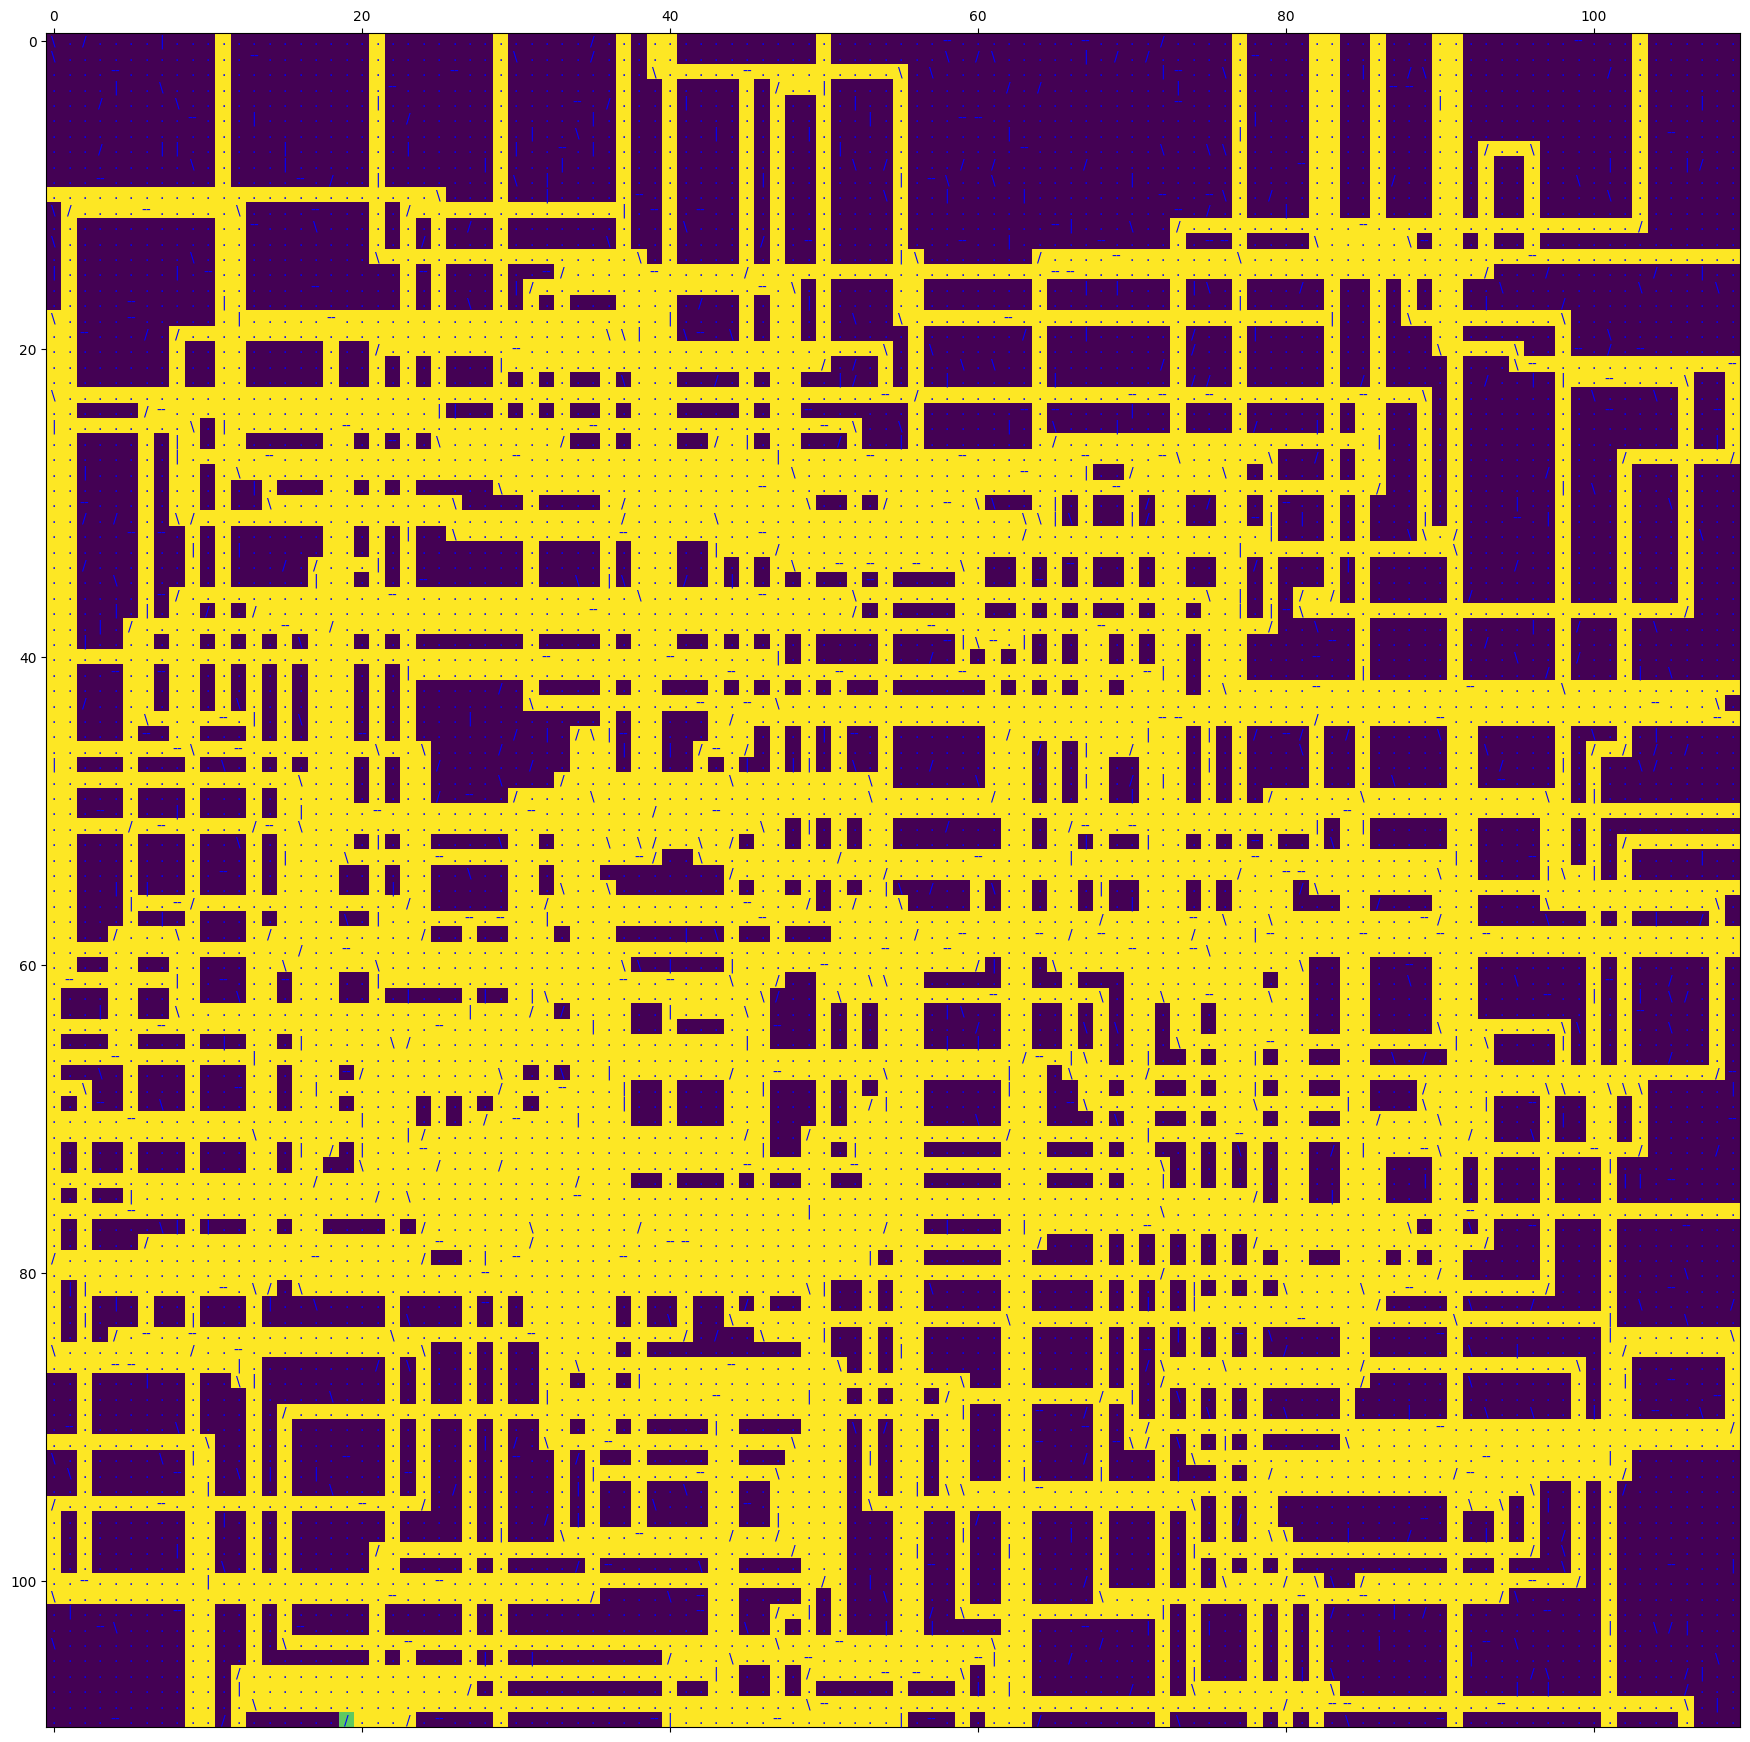

In [18]:
max_charged_tiles = find_charged_tiles(input_16, start_tile=(109, 19), start_direction='n')

visualise_charged_tiles(input_16, 
                        max_charged_tiles, 
                        max_start_tile, 
                        plot_factor=0.2)